In [399]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
from scipy.special import boxcox1p
import warnings

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import pandas as pd 
import numpy as np 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.preprocessing import LabelEncoder


from sklearn.compose import make_column_transformer
from itertools import combinations 


warnings.filterwarnings("ignore") # ignoring annoying warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1) 
pd.set_option("display.max_rows", 500)

###TO PREVENT SCROLLING : SHIFT + O

In [400]:
#I. DATA PREPARATION

In [401]:
# 1. READ THE WHOLE DATASET:
# We load and read the whole dataset (train + test) because we need to clean and preprocess all of it!!!!
#All the procedures must be applied to the entire dataset before split it!

#Step 1: Load train and test sets

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Target
target = "Loan_Status"

#Change target type
dict = {"Y":1, "N":0}
train[target] = train[target].map(dict)


In [402]:
train.shape, test.shape


((614, 13), (367, 12))

In [403]:
#2. Check for duplicates
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [404]:
#3. Separate datatypes
categorical = train.select_dtypes(["object", "bool"])
numerical = train.select_dtypes(["float", "int"])

In [405]:
#4. Initial data cleaning
"""Examples of things to consider...
• Are there categorical columns that should be numerical?
• Is the data in the first few rows consistent with the name of the feature?
• Are there lists or dictionaries packed into one feature?
• Are dates in the date data type?"""

'Examples of things to consider...\n• Are there categorical columns that should be numerical?\n• Is the data in the first few rows consistent with the name of the feature?\n• Are there lists or dictionaries packed into one feature?\n• Are dates in the date data type?'

In [406]:
#Changing some datatypes:
#Credit_History should be categorical
#Update for train and test
#train["Credit_History"] = train["Credit_History"].astype("object")
#test["Credit_History"] = test["Credit_History"].astype("object")

#Re-separate columns
categorical = train.select_dtypes(["object", "bool"])
numerical = train.select_dtypes(["float", "int"])

In [407]:
#Separate columns for nominal, ordinal and numerical features for analysis
nominal = ['Loan_ID', 'Gender', 'Married', 'Self_Employed' ]
ordinal = ["Dependents", 'Education','Property_Area']
num = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History']

nominal.remove("Loan_ID")



In [408]:
#II. EXPLORATORY DATA ANALYSIS
#Utils
def bar_plot_feat(data, cols): #bar plot of features
    for col in cols:
        data[col].value_counts(normalize = True).plot.bar(figsize = (7,4), title = col)
        plt.show()
        
def distplot_feat(data, cols):
    for col in cols:
        sns.distplot(data[col])
        plt.show()
        data[col].plot.box(figsize=(10,4))
        plt.show()
        
        
def bivariate(data, cols, target):
    for col in cols:
        df=pd.crosstab(data[col],data[target])
        df.div(df.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True,figsize=(6,6))
        plt.show()


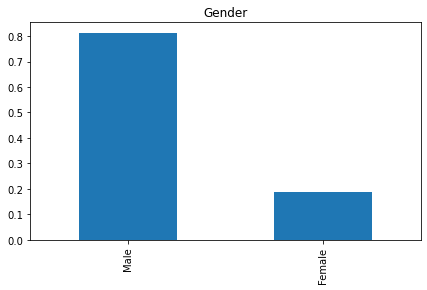

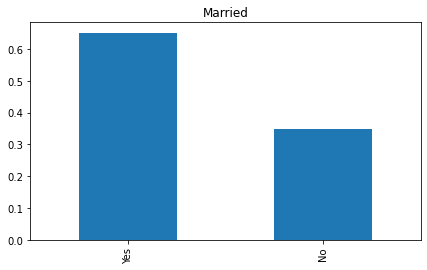

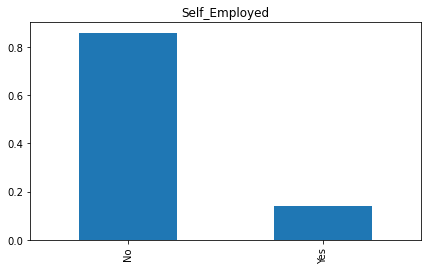

In [409]:
#II. 1 Univariate analysis for checking the dstribution
#Nominal features
#Train set
bar_plot_feat(train,nominal)

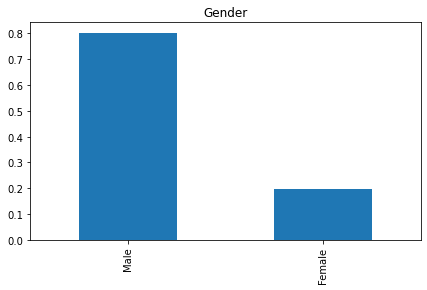

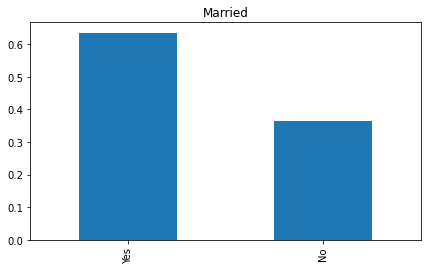

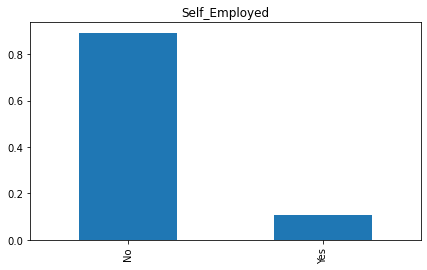

In [410]:
#Test set
bar_plot_feat(test,nominal)

In [411]:
#Observations on nominal data
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

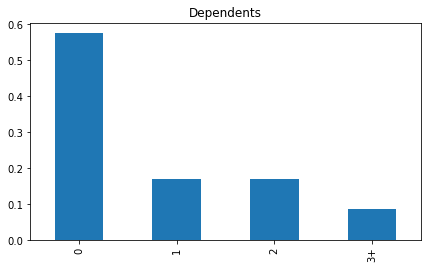

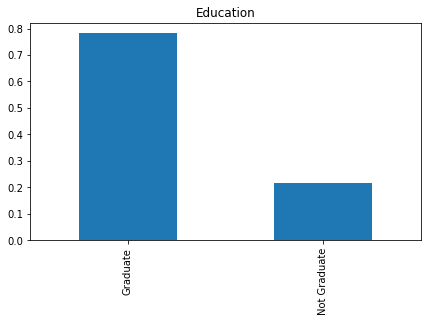

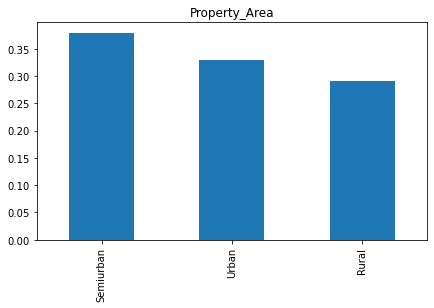

In [412]:
#Ordinal features
#Train set
bar_plot_feat(train,ordinal)

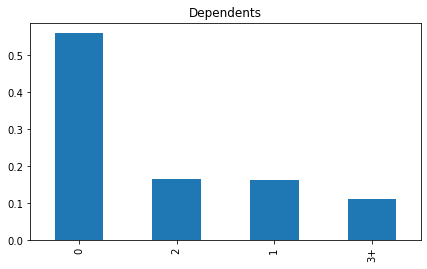

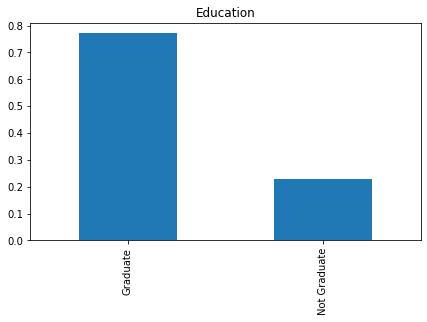

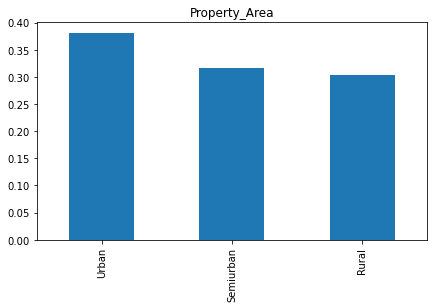

In [413]:
#Test set
bar_plot_feat(test,ordinal)

In [414]:
#Observations on nominals
#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas

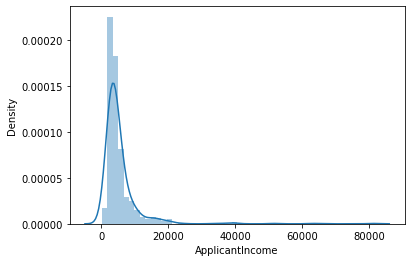

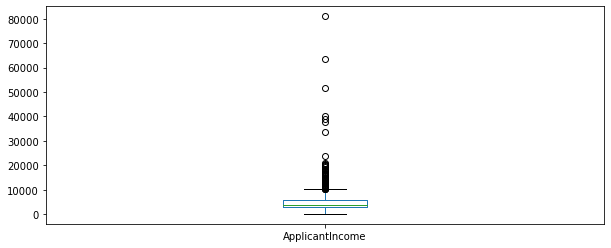

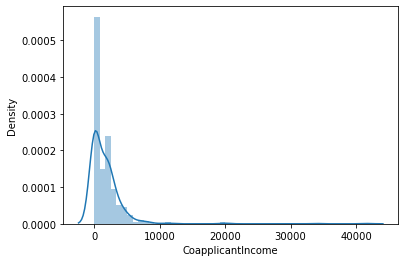

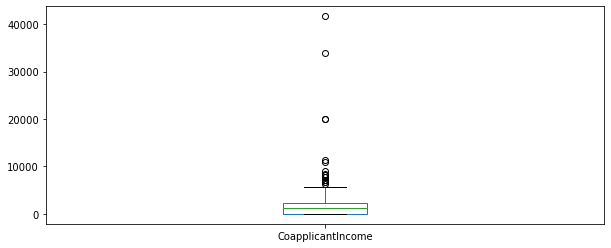

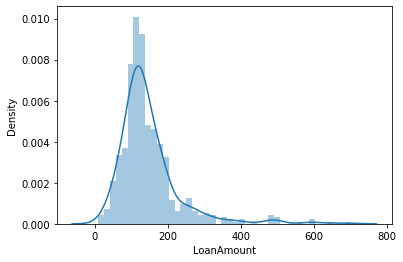

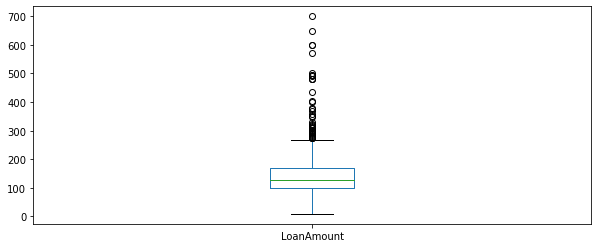

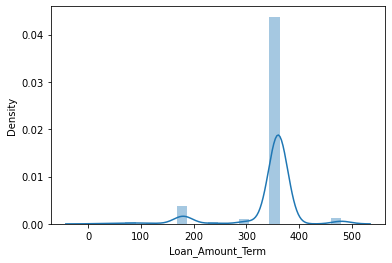

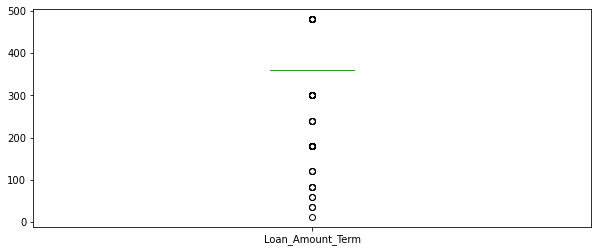

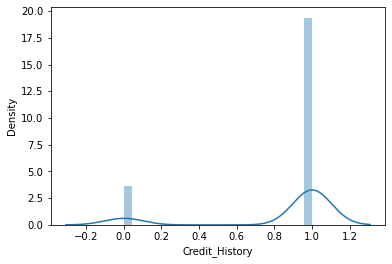

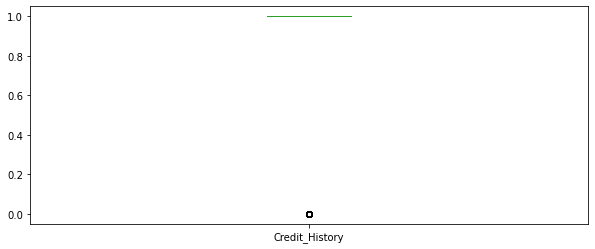

In [415]:
#Numerical features
#train test
distplot_feat(train, num)

In [416]:
#Describe
train[num].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [417]:
#Observaciones:
#ApplicantIncome: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#CoapplicantIncome: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#LoanAmount: right skewed, presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations
#Loan_Amount_Term: left skewed, no presence of outliers, central tendency measure is median, no modal/bimodal, no subpopulations

In [418]:
##General observations summary:
#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

#Get the medians of num for analysis:
for c in num:
    print(c, ":", train[c].median())

ApplicantIncome : 3812.5
CoapplicantIncome : 1188.5
LoanAmount : 128.0
Loan_Amount_Term : 360.0
Credit_History : 1.0


In [419]:
#TEST TAKING A SUBSET OF THE MOST COMMON CHARACTERISTICS IN DATASET AND SEE ITS TARGET DISTRIBUTION
filter = train[(train.Gender == "Male") & (train.Dependents == "0") & (train.Property_Area == "Urban") &
              (train.Education == "Graduate") & (train.Married == "Yes") & (train.Credit_History == 1)]

In [420]:
#Son pocos pero todos obtienen aprobacion
filter.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,1
35,LP001106,Male,Yes,0,Graduate,No,2275,2067.0,NaN,360.0,1.0,Urban,1
47,LP001144,Male,Yes,0,Graduate,No,5821,0.0,144.0,360.0,1.0,Urban,1
60,LP001205,Male,Yes,0,Graduate,No,2500,3796.0,120.0,360.0,1.0,Urban,1


In [421]:
#II.2 Bivariate Analysis
nominal

['Gender', 'Married', 'Self_Employed']

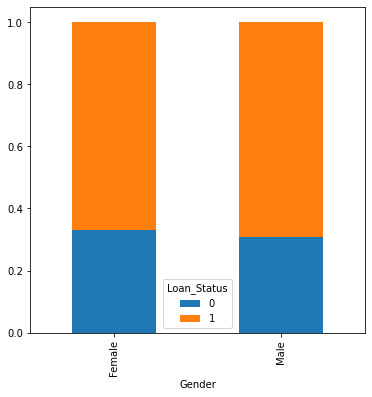

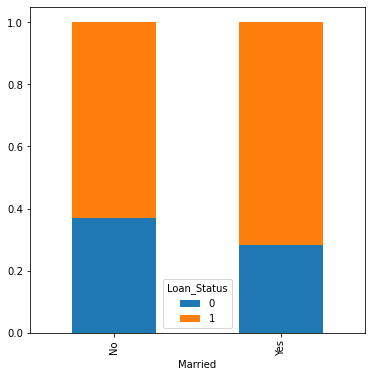

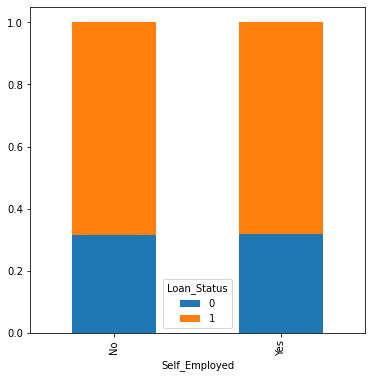

In [422]:
bivariate(train, nominal, "Loan_Status")

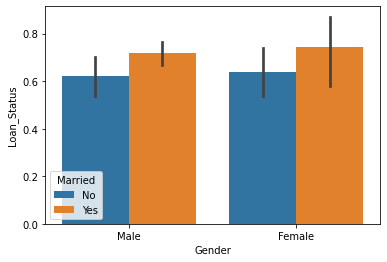

In [423]:
#Second layer: analysis of combined features

#Is there a difference in gender/married concerning loans?

#Updated insights:
#Married people have higher chances of getting the loan
#Married women have higher chances of getting a loan (the highest)
#(crear new feat Gender_Married)

ax = sns.barplot(x="Gender", y= target, hue = "Married", data=train)

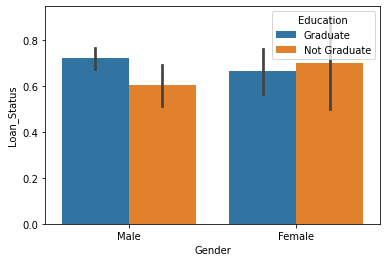

In [424]:
#Gender and Education
ax = sns.barplot(x="Gender", y= target, hue = "Education", data=train)

#Updated:
#Graduated men have higher chances of loan than non graduated
#NON-graduated women have higher chances than graduated women
#Graduated men have more chances of a loan than graduated women
#NON graduated women have more chances of loan that NON graduated men
#(new feature: Gender_Education)

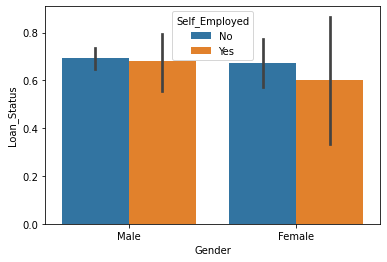

In [425]:
#Gender and Self_Employed
ax = sns.barplot(x="Gender", y= target, hue = "Self_Employed", data=train)
#Update:
#No self employed have higher chances of a loan
#No self employed women have higher chances than self-employed women
#(new feature: Gender_Self_Employed)

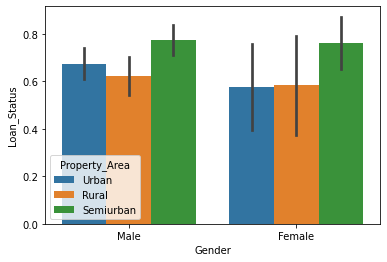

In [426]:
#Gender and Property_Area
ax = sns.barplot(x="Gender", y= target, hue = "Property_Area", data=train)

#Update:
#People applying for semiurban have the highest chances of a loan, men and women
#(new feature: Gender_Property_Area)

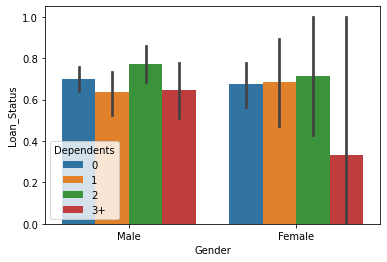

In [427]:
#Gender and Dependents
ax = sns.barplot(x="Gender", y= target, hue = "Dependents", data=train)

#Women with 3+ dependents have the lowes chances, half of men´s in the same situation
#Men with 2 dependents have higher chances than women with 2 dependends
#Men with 0 dependents have highee chances than women with 0 dependents
#In general, women with dependents have lower chances than men with dependents
#(new feature: Gender_Dependents)


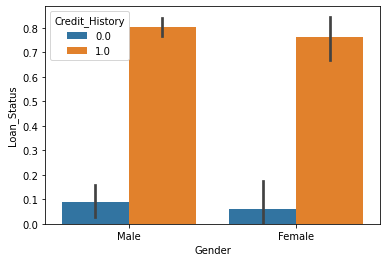

In [428]:
#Gender and Credit_History
ax = sns.barplot(x="Gender", y= target, hue = "Credit_History", data=train)
#Importance of credit history confirmed

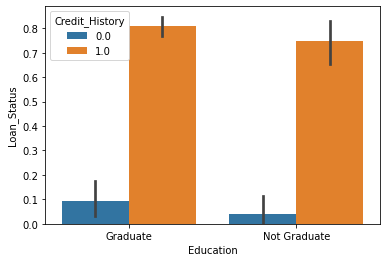

In [429]:
#Education and credit history
ax = sns.barplot(x="Education", y= target, hue = "Credit_History", data=train)

#Just confirms importance of history in both cases



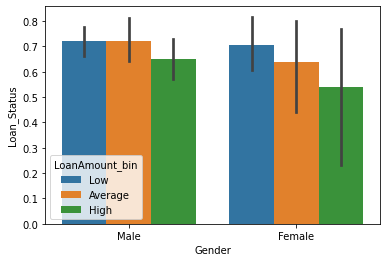

In [430]:
#Loan amount and Gender
#We must bin the feature first
t = train.copy()
bins=[0,130,170, 700]
group=["Low","Average","High"]
t["LoanAmount_bin"]=pd.cut(t["LoanAmount"],bins,labels=group)

ax = sns.barplot(x="Gender", y= target, hue = "LoanAmount_bin", data= t)

#Men have higher chances of getting high amount loans than women
##Men have higher chances of getting average amount loans than women
#(new feature: Gender_LoanAmount_bin)




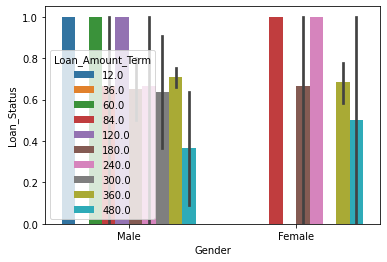

In [431]:
#Gender and term
ax = sns.barplot(x="Gender", y= target, hue = "Loan_Amount_Term", data= train)
#Update:
#Several differences in gender for loan terms
#Women hab higher chances of getting a long term loan than men
#(new feature: Gender_Loan_Amount_Term)


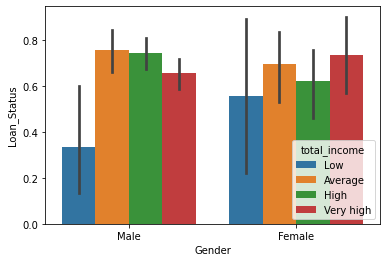

In [433]:
#Gender and CoapplicantIncome + ApplicantINcome
t = train.copy()
t["total_income"] = t["ApplicantIncome"] + t["CoapplicantIncome"]
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]

t["total_income"]=pd.cut(t["total_income"],bins,labels=group)
ax = sns.barplot(x="Gender", y= target, hue = "total_income", data= t)

#Update:
#women with very high total income have more chances of gettin a loan than men with hig total income
#Men with average and high have more chances than women with average and high
#Women with low total income have more chances than men with low total income
#new feature: Gender_total_income)


In [384]:
numerical.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

In [333]:
#Observ:

#Genero no influye en otorgamiento del credito
#Married applicants have more chances to get a loan
#Self employed is irrelevant
#80% of people with good history get the loan, while 90% of those with no record dont get it ***

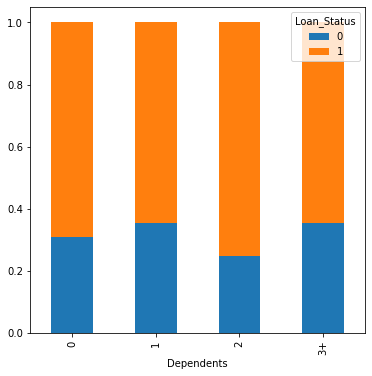

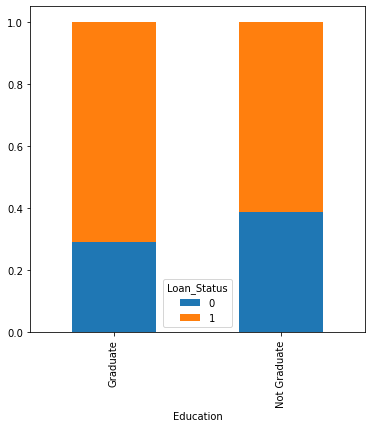

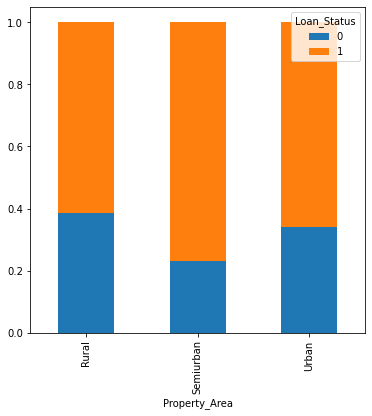

In [334]:
#Ordinal
bivariate(train, ordinal, "Loan_Status")

In [335]:
#Dependants 2 and 0 have the highest chance of getting the loan
#Graduates have higher chance (70% versus 60%)
#Semiurban Property_Area have the highest chance (80%)

In [336]:
#Numerical
#Dado que son valores dispersos y continuos, se binea pero solo para el analisis

In [337]:
train[num].describe(include = "all")

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


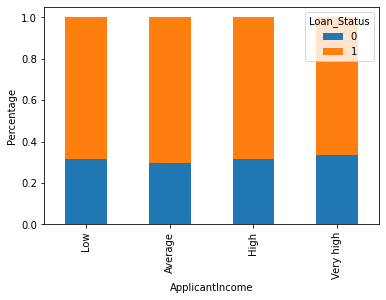

In [338]:
#ApplicantIncome
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]
train["Income_bin"]=pd.cut(train["ApplicantIncome"],bins,labels=group)
Income_bin=pd.crosstab(train["Income_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("ApplicantIncome")
P=plt.ylabel("Percentage")

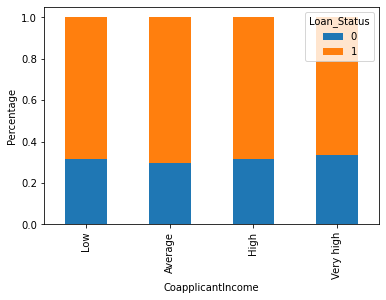

In [339]:
#CoapplicantIncome
bins=[0,1200,2300,42000]
group=["Low","Average","High"]
train["Coapplicant_Income_bin"]=pd.cut(train["CoapplicantIncome"],bins,labels=group)
Income_bin=pd.crosstab(train["Income_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("CoapplicantIncome")
P=plt.ylabel("Percentage")

In [340]:
#Se ve que cuando el ingreso del coapplicant es el mas bajo es cuando mayor probabilidad hay de loan, nosense
#Hay valores 0 de coapplicant, por lo que puede que se trata de que no hay coapplicant.
#Creo un nuevo feat que suma los ingresos y analizo
train["total_income"] = train["ApplicantIncome"] + train["CoapplicantIncome"]


#CoapplicantIncome
#ApplicantIncome
train["total_income"].describe()

count    614.000000  
mean     7024.705081 
std      6458.663872 
min      1442.000000 
25%      4166.000000 
50%      5416.500000 
75%      7521.750000 
max      81000.000000
Name: total_income, dtype: float64

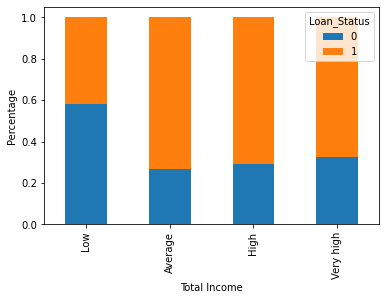

In [341]:
#bins=[0,4200,5500,7600,81000]
bins=[0,2500,4000,6000,81000]
group=["Low","Average","High","Very high"]
train["total_income"]=pd.cut(train["total_income"],bins,labels=group)
Income_bin=pd.crosstab(train["total_income"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("Total Income")
P=plt.ylabel("Percentage")

In [342]:
#Those with LOW income class have LESS chances of getting the loan (60%)

In [343]:
train.LoanAmount.describe()

count    592.000000
mean     146.412162
std      85.587325 
min      9.000000  
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

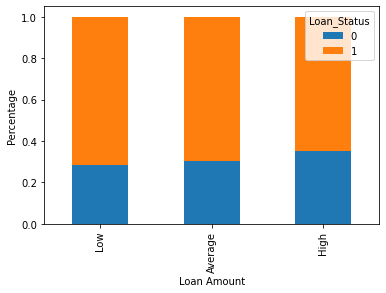

In [344]:
#LoanAmount
bins=[0,130,170, 700]
group=["Low","Average","High"]
train["LoanAmount_bin"]=pd.cut(train["LoanAmount"],bins,labels=group)
Income_bin=pd.crosstab(train["LoanAmount_bin"],train["Loan_Status"])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind="bar",stacked=True)
plt.xlabel("Loan Amount")
P=plt.ylabel("Percentage")


In [345]:
#Se ve que para los low and average  loan amounts hay mas chance de tener el loan

In [346]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Income_bin', 'Coapplicant_Income_bin', 'total_income',
       'LoanAmount_bin'],
      dtype='object')

In [347]:
#Drop the created bin columns, bacause they were for analysis only
train.drop(['Income_bin', 'Coapplicant_Income_bin', 'total_income','LoanAmount_bin', 
            "total_income"], axis = 1, inplace = True)


In [348]:
#Replace +3 in Dependants by 3

train["Dependents"].replace("3+", 3,inplace=True)
test["Dependents"].replace("3+", 3,inplace=True)



In [349]:
##Summary of observations from EDA:

#Both in train and test sets we see data contains a majority of: graduates with 0 dependents, and more 
#than 65% are applyying for urban or semi urban property_areas
#Both in train and test sets we see data contains a majority of: men, married, credit history of payment,
#and not self-employees 

#Genero no influye en otorgamiento del credito
#Married applicants have more chances to get a loan
#Self employed is irrelevant
#80% of people with good history get the loan, while 90% of those with no record dont get it ***

#Dependants 2 and 0 have the highest chance of getting the loan
#Graduates have higher chance (70% versus 60%)
#Semiurban Property_Area have the highest chance (80%)

#Loan is indifferent to applicantincome
#Those with LOW income class have LESS chances of getting the loan (60%)
#Se ve que para los low and average  loan amounts hay mas chance de tener el loan


#Most relevant features: Credit_History, loan_amount, Semiurban Property_Area, education graduated, dependents 2 and 0, married

#Irrelevan: Genre, self employed, ApplicantIncome




<AxesSubplot:>

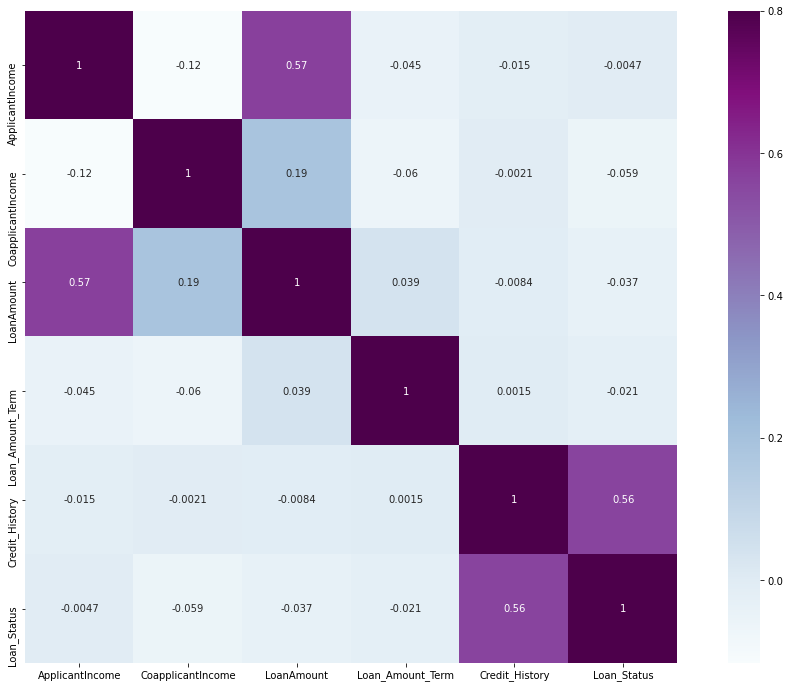

In [350]:
#II.3 CORRELATION ANALYSIS
matrix = train.corr()
f, ax = plt.subplots(figsize = (18,12))
sns.heatmap(matrix, vmax = 0.8, square = True, cmap = "BuPu", annot = True)

In [352]:
#The highest correlation is between LOanAmount and Applicant Income
#The highest correlation with target is Credit History

#Observation: el otorgamiento de prestamo depende en gran medida del credit hstory, y de los ingresos del aval
#y el monto a prestar en segundo y tercer termino